# IST597 :Recurrent Neural Networks (RNNs) for sequence classification
Thanks to @googleAI, @Keras, @madlalina @nvidia_research 
----

We will be  building a RNN for sentiment analysis on IMDB movie reviews ( [stanford_imdb](https://https://ai.stanford.edu/~amaas/data/sentiment/)). 


In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(5510)

In [3]:
import sys
sys.path.insert(1,'/content/')
from data_utils import parse_imdb_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


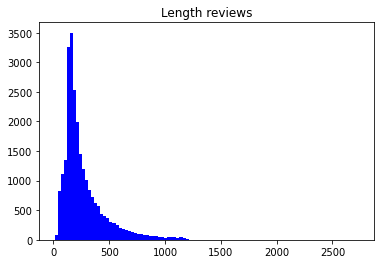

In [4]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [12]:

train_dataset = tf.data.TFRecordDataset('/content/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))
test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [15]:
train_dataset = list(train_dataset)

In [16]:
train_dataset = list(train_dataset)

In [17]:
train_data, val_data = train_dataset[:40], train_dataset[40:]


In [18]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](https://github.com/AnkurMali/IST597_Spring_2022/blob/main/tutorials_graphics/rnn_imdb.png?raw=1)

In [19]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, test_dataset, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        test_acc = tf.keras.metrics.Accuracy('test_acc')
        val_acc = tf.keras.metrics.Accuracy('val_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        self.history['val_acc'] = []
        self.history['test_acc'] =[]
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(train_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(train_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy val dataset
                for step, (X, y, seq_length) in enumerate(val_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    val_acc(preds, y)
                self.history['val_acc'].append(val_acc.result().numpy())
                # Reset metrics
                val_acc.reset_states()
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(test_dataset):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    test_acc(preds, y)
                self.history['test_acc'].append(test_acc.result().numpy())
                # Reset metrics
                test_acc.reset_states()

                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('val accuracy at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    print('test accuracy at epoch %d: ' %(i+1), self.history['test_acc'][-1])

                # Check for early stopping
                if self.history['val_acc'][-1]>best_acc:
                    best_acc = self.history['val_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train model with gradient descent and early stopping
----

### Model training with simple LSTM cells
----

In [53]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [54]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=10, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.6956543
val accuracy at epoch 1:  0.66681415
test accuracy at epoch 1:  0.65916
Train accuracy at epoch 2:  0.81279296
val accuracy at epoch 2:  0.78650445
test accuracy at epoch 2:  0.78372
Train accuracy at epoch 3:  0.8727539
val accuracy at epoch 3:  0.8466814
test accuracy at epoch 3:  0.82652
Train accuracy at epoch 4:  0.9055664
val accuracy at epoch 4:  0.8599557
test accuracy at epoch 4:  0.831
Train accuracy at epoch 5:  0.9423828
val accuracy at epoch 5:  0.8840708
test accuracy at epoch 5:  0.86604
Train accuracy at epoch 6:  0.9608887
val accuracy at epoch 6:  0.89026546
test accuracy at epoch 6:  0.87328
Train accuracy at epoch 7:  0.97280276
val accuracy at epoch 7:  0.8960177
test accuracy at epoch 7:  0.87892
Train accuracy at epoch 8:  0.9802246
val accuracy at epoch 8:  0.8918142
test accuracy at epoch 8:  0.87604
Train accuracy at epoch 9:  0.9830078
val accuracy at epoch 9:  0.88628316
test accuracy at epoch 9:  0.86956
Train accuracy 

In [22]:
#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model)
save_path = checkpoint.save(checkpoint_directory)

### Model training with RNN cells 
---

In [23]:
# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.


In [24]:
# Train model
ugrnn_model.fit(train_data, val_data, test_dataset,optimizer, num_epochs=50, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.57612306
val accuracy at epoch 1:  0.5581858
test accuracy at epoch 1:  0.55524
Train accuracy at epoch 2:  0.7362793
val accuracy at epoch 2:  0.66172564
test accuracy at epoch 2:  0.65668
Train accuracy at epoch 3:  0.88686526
val accuracy at epoch 3:  0.8506637
test accuracy at epoch 3:  0.84288
Train accuracy at epoch 4:  0.93242186
val accuracy at epoch 4:  0.8785398
test accuracy at epoch 4:  0.86256
Train accuracy at epoch 5:  0.9144043
val accuracy at epoch 5:  0.8519912
test accuracy at epoch 5:  0.828
Train accuracy at epoch 6:  0.9577637
val accuracy at epoch 6:  0.88318586
test accuracy at epoch 6:  0.85616
Train accuracy at epoch 7:  0.97265625
val accuracy at epoch 7:  0.88893807
test accuracy at epoch 7:  0.87192
Train accuracy at epoch 8:  0.97939456
val accuracy at epoch 8:  0.8909292
test accuracy at epoch 8:  0.8712
Train accuracy at epoch 9:  0.9579102
val accuracy at epoch 9:  0.8570796
test accuracy at epoch 9:  0.85228
Train accuracy

### Performance comparison
---

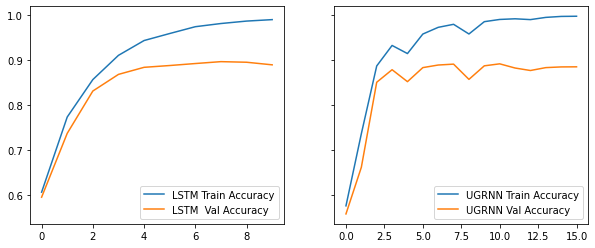

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         label='UGRNN Val Accuracy');
ax1.legend();
ax2.legend();

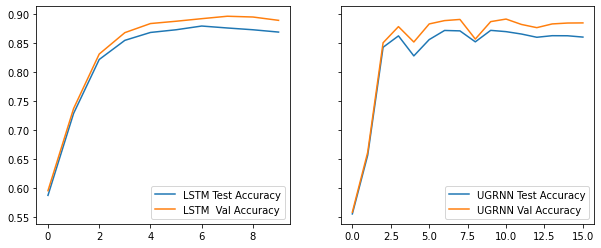

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['test_acc'])), lstm_model.history['test_acc'], 
         label='LSTM Test Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
ax2.plot(range(len(ugrnn_model.history['test_acc'])), ugrnn_model.history['test_acc'],
         label='UGRNN Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         label='UGRNN Val Accuracy');
ax1.legend();
ax2.legend();

As we can see that LSTM performed better thaan UGRNN, so I am going to take that as my baseline model and perform hyperparameter tuning.

Having Gradient Descent Optimzer and changing learning rate to 0.002

In [52]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, test_dataset, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        test_acc = tf.keras.metrics.Accuracy('test_acc')
        val_acc = tf.keras.metrics.Accuracy('val_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        self.history['val_acc'] = []
        self.history['test_acc'] =[]
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(train_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(train_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy val dataset
                for step, (X, y, seq_length) in enumerate(val_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    val_acc(preds, y)
                self.history['val_acc'].append(val_acc.result().numpy())
                # Reset metrics
                val_acc.reset_states()
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(test_dataset):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    test_acc(preds, y)
                self.history['test_acc'].append(test_acc.result().numpy())
                # Reset metrics
                test_acc.reset_states()

                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('val accuracy at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    print('test accuracy at epoch %d: ' %(i+1), self.history['test_acc'][-1])

                # Check for early stopping
                if self.history['val_acc'][-1]>best_acc:
                    best_acc = self.history['val_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

In [29]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-3)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [30]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=10, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.4980957
val accuracy at epoch 1:  0.5086283
test accuracy at epoch 1:  0.5
Train accuracy at epoch 2:  0.4980957
val accuracy at epoch 2:  0.5086283
test accuracy at epoch 2:  0.5
Train accuracy at epoch 3:  0.4980957
val accuracy at epoch 3:  0.5086283
test accuracy at epoch 3:  0.5
Train accuracy at epoch 4:  0.4980957
val accuracy at epoch 4:  0.5086283
test accuracy at epoch 4:  0.5
Train accuracy at epoch 5:  0.4980957
val accuracy at epoch 5:  0.5086283
test accuracy at epoch 5:  0.5
Train accuracy at epoch 6:  0.4980957
val accuracy at epoch 6:  0.5086283
test accuracy at epoch 6:  0.5


In [31]:
#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model)
save_path = checkpoint.save(checkpoint_directory)

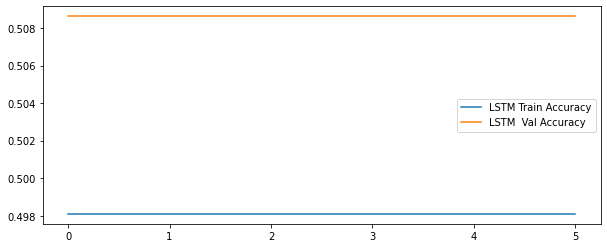

In [32]:
f, (ax1) = plt.subplots(1,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
#ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
        # label='UGRNN Train Accuracy');
#ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         #label='UGRNN Val Accuracy');
ax1.legend();
#ax2.legend();

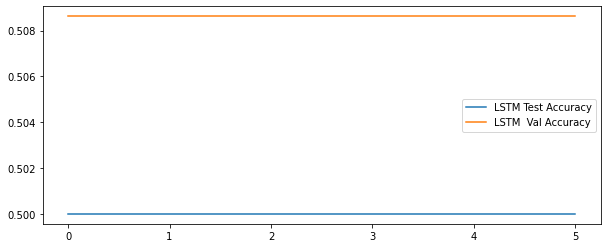

In [33]:
f, (ax1) = plt.subplots(1, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['test_acc'])), lstm_model.history['test_acc'], 
         label='LSTM Test Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
'''
ax2.plot(range(len(ugrnn_model.history['test_acc'])), ugrnn_model.history['test_acc'],
        label='UGRNN Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],

         label='UGRNN Val Accuracy');
'''
ax1.legend();
#ax2.legend();

Clearly, changing the Optimizer from Adam to Gradientdecent resulted in the poor performance of the model.

Therefore, I have changed the optimizer to Adagrad, while keeping the learning rate same that is 0.00001

In [34]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdagradOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [35]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=10, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.5433594
val accuracy at epoch 1:  0.55088496
test accuracy at epoch 1:  0.53476
Train accuracy at epoch 2:  0.55185544
val accuracy at epoch 2:  0.55
test accuracy at epoch 2:  0.54068
Train accuracy at epoch 3:  0.5523926
val accuracy at epoch 3:  0.5550885
test accuracy at epoch 3:  0.5444
Train accuracy at epoch 4:  0.55498046
val accuracy at epoch 4:  0.5535398
test accuracy at epoch 4:  0.54652
Train accuracy at epoch 5:  0.5574707
val accuracy at epoch 5:  0.5599558
test accuracy at epoch 5:  0.54936
Train accuracy at epoch 6:  0.5628418
val accuracy at epoch 6:  0.5679203
test accuracy at epoch 6:  0.55424
Train accuracy at epoch 7:  0.5672363
val accuracy at epoch 7:  0.5710177
test accuracy at epoch 7:  0.55964
Train accuracy at epoch 8:  0.5734863
val accuracy at epoch 8:  0.57986724
test accuracy at epoch 8:  0.56532
Train accuracy at epoch 9:  0.5800781
val accuracy at epoch 9:  0.5834071
test accuracy at epoch 9:  0.57024
Train accuracy at epo

In [36]:
#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model)
save_path = checkpoint.save(checkpoint_directory)

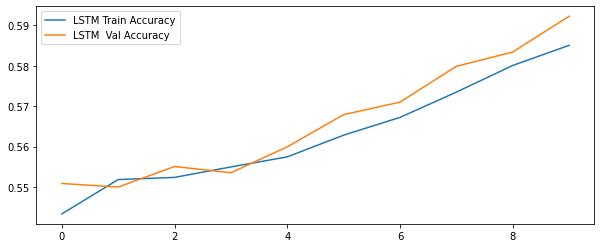

In [37]:
f, (ax1) = plt.subplots(1,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
#ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
        # label='UGRNN Train Accuracy');
#ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         #label='UGRNN Val Accuracy');
ax1.legend();
#ax2.legend();

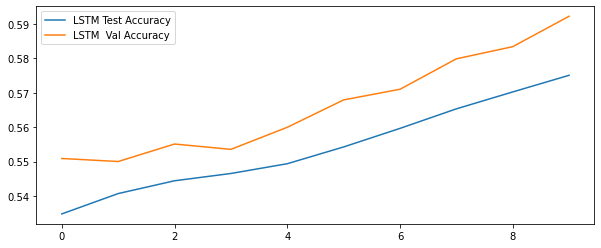

In [38]:
f, (ax1) = plt.subplots(1, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['test_acc'])), lstm_model.history['test_acc'], 
         label='LSTM Test Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
'''
ax2.plot(range(len(ugrnn_model.history['test_acc'])), ugrnn_model.history['test_acc'],
        label='UGRNN Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],

         label='UGRNN Val Accuracy');
'''
ax1.legend();
#ax2.legend();

Since, Both the gradient descent optimizer and Adagrad performed poorly as compared to the Adam, so we are going to keep adam and try to change the learning rate, I will decrease the learning rate to 0.0002

In [39]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=2e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [40]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=10, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.81992185
val accuracy at epoch 1:  0.789823
test accuracy at epoch 1:  0.78724
Train accuracy at epoch 2:  0.8952637
val accuracy at epoch 2:  0.8528761
test accuracy at epoch 2:  0.84032
Train accuracy at epoch 3:  0.93422854
val accuracy at epoch 3:  0.88030976
test accuracy at epoch 3:  0.86924
Train accuracy at epoch 4:  0.9627441
val accuracy at epoch 4:  0.88893807
test accuracy at epoch 4:  0.87488
Train accuracy at epoch 5:  0.9765625
val accuracy at epoch 5:  0.8940266
test accuracy at epoch 5:  0.87964
Train accuracy at epoch 6:  0.9698242
val accuracy at epoch 6:  0.8829646
test accuracy at epoch 6:  0.86984
Train accuracy at epoch 7:  0.98481447
val accuracy at epoch 7:  0.88495576
test accuracy at epoch 7:  0.85932
Train accuracy at epoch 8:  0.9586914
val accuracy at epoch 8:  0.8581858
test accuracy at epoch 8:  0.8194
Train accuracy at epoch 9:  0.9845215
val accuracy at epoch 9:  0.884292
test accuracy at epoch 9:  0.85592
Train accuracy a

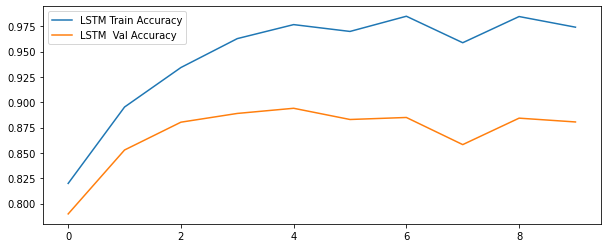

In [41]:
f, (ax1) = plt.subplots(1,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
#ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
        # label='UGRNN Train Accuracy');
#ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         #label='UGRNN Val Accuracy');
ax1.legend();
#ax2.legend();

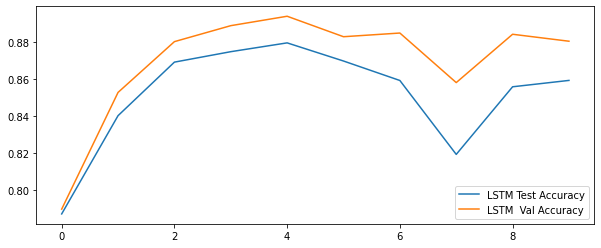

In [42]:
f, (ax1) = plt.subplots(1, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['test_acc'])), lstm_model.history['test_acc'], 
         label='LSTM Test Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
'''
ax2.plot(range(len(ugrnn_model.history['test_acc'])), ugrnn_model.history['test_acc'],
        label='UGRNN Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],

         label='UGRNN Val Accuracy');
'''
ax1.legend();
#ax2.legend();

It resulted in a little decrease in the accuracy, so I will try to use lr as 0.0003

In [43]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=3e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [44]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=10, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.80507815
val accuracy at epoch 1:  0.775
test accuracy at epoch 1:  0.76664
Train accuracy at epoch 2:  0.92348635
val accuracy at epoch 2:  0.87876105
test accuracy at epoch 2:  0.8694
Train accuracy at epoch 3:  0.9590332
val accuracy at epoch 3:  0.889823
test accuracy at epoch 3:  0.88044
Train accuracy at epoch 4:  0.9771484
val accuracy at epoch 4:  0.8942478
test accuracy at epoch 4:  0.86756
Train accuracy at epoch 5:  0.9902832
val accuracy at epoch 5:  0.8938053
test accuracy at epoch 5:  0.8772
Train accuracy at epoch 6:  0.99135745
val accuracy at epoch 6:  0.88030976
test accuracy at epoch 6:  0.86528
Train accuracy at epoch 7:  0.9957031
val accuracy at epoch 7:  0.8858407
test accuracy at epoch 7:  0.86072
Train accuracy at epoch 8:  0.9803711
val accuracy at epoch 8:  0.87234515
test accuracy at epoch 8:  0.84172
Train accuracy at epoch 9:  0.98515624
val accuracy at epoch 9:  0.8732301
test accuracy at epoch 9:  0.84584


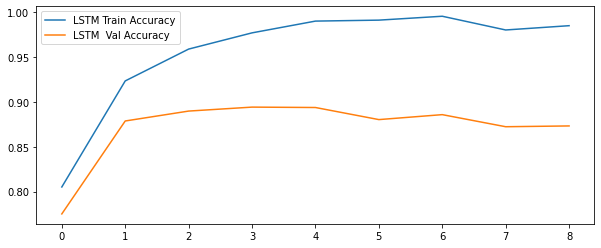

In [45]:
f, (ax1) = plt.subplots(1,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
#ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
        # label='UGRNN Train Accuracy');
#ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         #label='UGRNN Val Accuracy');
ax1.legend();
#ax2.legend();

So, I noticed that at certain epoch, we got a good accuracy, So I will be reducing the epochs.

In [49]:
# Train model
lstm_model.fit(train_data, val_data, test_dataset, optimizer, num_epochs=4, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

Train accuracy at epoch 1:  0.9760742
val accuracy at epoch 1:  0.87588495
test accuracy at epoch 1:  0.84528
Train accuracy at epoch 2:  0.99067384
val accuracy at epoch 2:  0.8869469
test accuracy at epoch 2:  0.86724
Train accuracy at epoch 3:  0.9904297
val accuracy at epoch 3:  0.88030976
test accuracy at epoch 3:  0.86008
Train accuracy at epoch 4:  0.99746096
val accuracy at epoch 4:  0.88606197
test accuracy at epoch 4:  0.86172


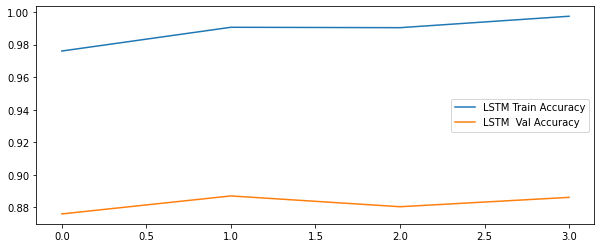

In [50]:
f, (ax1) = plt.subplots(1,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
#ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
        # label='UGRNN Train Accuracy');
#ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],
         #label='UGRNN Val Accuracy');
ax1.legend();
#ax2.legend();

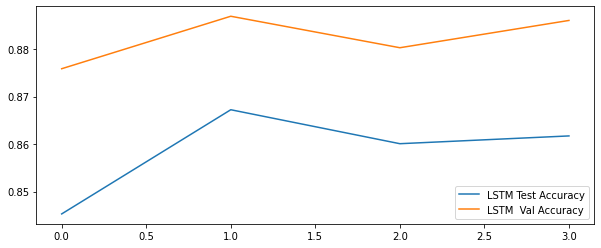

In [51]:
f, (ax1) = plt.subplots(1, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['test_acc'])), lstm_model.history['test_acc'], 
         label='LSTM Test Accuracy');
ax1.plot(range(len(lstm_model.history['val_acc'])), lstm_model.history['val_acc'], 
         label='LSTM  Val Accuracy');
'''
ax2.plot(range(len(ugrnn_model.history['test_acc'])), ugrnn_model.history['test_acc'],
        label='UGRNN Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['val_acc'])), ugrnn_model.history['val_acc'],

         label='UGRNN Val Accuracy');
'''
ax1.legend();
#ax2.legend();

## Test network on new samples
---



In [55]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [56]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [57]:
sent_dict = {0: 'negative', 1: 'positive'}

In [58]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [59]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [60]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [61]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [62]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative
